<a href="https://www.kaggle.com/code/arshnoor7389/sentiment-analysis-on-hospital-comments?scriptVersionId=136192458" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Sentiment Analysis 
- Private dataset with sensitive hospital comments 

# Importing Packages

In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import spacy
import en_core_web_sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')

! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp fix for lookup error.

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


In [3]:
df = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv")

# Preprocessing the Dataset 

In [4]:
df.columns = ["id_no","Main Topic","Subtopic","Content"]
#df["Main Topic"] = df["Main Topic"].fillna("No Topic Given")
df = df.dropna(subset=["Content"])
nan_counts = df.isna().sum()

print(nan_counts)

id_no         0
Main Topic    0
Subtopic      0
Content       0
dtype: int64


In [5]:
# Defining regex patterns.
linebreaks        = "<br /><br />"
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

stop_words = set(stopwords.words('english'))
Lemmatizer = WordNetLemmatizer()

In [6]:
def preprocess_reviews(review):

    review = review.lower()

    review = re.sub(linebreaks," ",review)
    # Replace 3 or more consecutive letters by 2 letter.
    review = re.sub(sequencePattern, seqReplacePattern, review)

    # Replace all emojis.
    review = re.sub(r'<3', '<heart>', review)
    review = re.sub(smileemoji, '<smile>', review)
    review = re.sub(sademoji, '<sadface>', review)
    review = re.sub(neutralemoji, '<neutralface>', review)
    review = re.sub(lolemoji, '<lolface>', review)

    # Remove non-alphanumeric and symbols
    review = re.sub(alphaPattern, ' ', review)
    
    # Tokenize the input text
    tokens = word_tokenize(review)
    
    # Remove stop words from the token sequence

    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize the remaining tokens
    tokens = [Lemmatizer.lemmatize(token) for token in tokens]
    
    # Join the cleaned tokens into a single string
    return ' '.join(tokens)
    

In [7]:
# combine "Main Topic", "Subtopic", and "Content" columns into a single column called "Text"
df["Text"] = df["Main Topic"] + " " + df["Subtopic"] + " " + df["Content"]

In [8]:
df["Text"] = df["Text"].apply(preprocess_reviews)

# Keyword and Sentiment Analysis using Word2Vec 
- Reference Article: https://towardsdatascience.com/unsupervised-semantic-sentiment-analysis-of-imdb-reviews-2c5f520fbf81

In [9]:
!curl https://raw.githubusercontent.com/towardsNLP/IMDB-Semantic-Sentiment-Analysis/main/Word2Vec/src/w2v_utils.py -o w2v_utils.py

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25779  100 25779    0     0  70053      0 --:--:-- --:--:-- --:--:-- 70051


In [10]:
from w2v_utils import (Tokenizer,
                       evaluate_model,
                       bow_vectorizer,
                       train_logistic_regressor,
                       w2v_trainer,
                       calculate_overall_similarity_score,
                       overall_semantic_sentiment_analysis,
                       list_similarity,
                       calculate_topn_similarity_score,
                       topn_semantic_sentiment_analysis,
                       define_complexity_subjectivity_reviews,
                       explore_high_complexity_reviews,
                       explore_low_subjectivity_reviews,
                       text_SSA)

In [11]:

# Instancing the Tokenizer class
tokenizer = Tokenizer(clean= True,
                      lower= True, 
                      de_noise= True, 
                      remove_stop_words= True,
                      keep_negation=True)


In [12]:
df['tokenized_text'] = df['Text'].apply(tokenizer.tokenize)

df['tokenized_text_len'] = df['tokenized_text'].apply(len)
df['tokenized_text_len'].apply(np.log).describe()

count    73995.000000
mean         2.420852
std          0.659979
min          0.693147
25%          1.945910
50%          2.484907
75%          2.890372
max          5.105945
Name: tokenized_text_len, dtype: float64

In [13]:
keyed_vectors , keyed_vocab = w2v_trainer(df["tokenized_text"])

In [14]:
print(type(keyed_vectors))
print(type(keyed_vocab))

<class 'gensim.models.keyedvectors.KeyedVectors'>
<class 'dict'>


In [15]:
keyed_vectors.most_similar("research",topn=15)

[('discontinuation', 0.8007424473762512),
 ('financial', 0.7727863192558289),
 ('enterprise', 0.7685366868972778),
 ('lilly', 0.7663764357566833),
 ('physician', 0.7557494640350342),
 ('mitra', 0.7551948428153992),
 ('healthcare', 0.7534245848655701),
 ('eli', 0.7516157031059265),
 ('medical', 0.7425392866134644),
 ('pharmaceutical', 0.7422808408737183),
 ('quadrant', 0.7421005368232727),
 ('enhances', 0.7347287535667419),
 ('ppc', 0.7343415021896362),
 ('electronics', 0.733647346496582),
 ('thesis', 0.733234167098999)]

In [16]:
keyed_vectors.most_similar("hospital",topn=15)

[('bare', 0.7548486590385437),
 ('coloured', 0.7485503554344177),
 ('predominantly', 0.7483745217323303),
 ('coat', 0.7344321608543396),
 ('biden', 0.7306110858917236),
 ('supremacy', 0.7150229811668396),
 ('beanie', 0.6990708708763123),
 ('jfc', 0.6985341906547546),
 ('lording', 0.6953385472297668),
 ('surpemacy', 0.694250226020813),
 ('mob', 0.6912442445755005),
 ('shill', 0.6905613541603088),
 ('keanu', 0.6886057257652283),
 ('morgan', 0.6854754686355591),
 ('precious', 0.6831064224243164)]

In [17]:
keyed_vectors.most_similar("funded",topn=15)

[('quintessential', 0.8546699285507202),
 ('northeast', 0.8513469696044922),
 ('quintet', 0.8441075682640076),
 ('a100', 0.8417577147483826),
 ('dbongi', 0.840761125087738),
 ('wristwraps', 0.8397045731544495),
 ('237', 0.8396622538566589),
 ('737', 0.8389871120452881),
 ('broad', 0.8382962346076965),
 ('satya', 0.8373106122016907),
 ('klillico72', 0.8367807269096375),
 ('x3mem3ktor', 0.8354833126068115),
 ('independently', 0.8347221612930298),
 ('appsec', 0.8340339660644531),
 ('cm9vpnukq0', 0.833867609500885)]

# Clustering Approach to Sentiment Analysis

In [18]:
# To make sure that all `positive_concepts` are in the keyed word2vec vocabulary
positive_concepts = ['excellent', 'awesome', 'cool','decent','amazing', 'strong', 'good', 'great', 'funny', 'entertaining'] 
pos_concepts = [concept for concept in positive_concepts if concept in keyed_vocab]

In [19]:
# To make sure that all `negative_concepts` are in the keyed word2vec vocabulary 
negative_concepts = ['terrible','awful','horrible','boring','bad', 'disappointing', 'weak', 'poor',  'senseless','confusing'] 
neg_concepts = [concept for concept in negative_concepts if concept in keyed_vocab]


In [20]:
# Calculating Semantic Sentiment Scores by OSSA model
overall_df_scores = overall_semantic_sentiment_analysis (keyed_vectors = keyed_vectors,
                                                   positive_target_tokens = pos_concepts, 
                                                   negative_target_tokens = neg_concepts,
                                                   doc_tokens = df['tokenized_text'])

# Calculating Semantic Sentiment Scores by TopSSA model
topn_df_scores = topn_semantic_sentiment_analysis (keyed_vectors = keyed_vectors,
                                                   positive_target_tokens = pos_concepts, 
                                                   negative_target_tokens = neg_concepts,
                                                   doc_tokens = df['tokenized_text'],
                                                     topn=30)


# To store semantic sentiment store computed by OSSA model in df
df['overall_PSS'] = overall_df_scores[0] 
df['overall_NSS'] = overall_df_scores[1] 
df['overall_semantic_sentiment_score'] = overall_df_scores[2] 
df['overall_semantic_sentiment_polarity'] = overall_df_scores[3]



# To store semantic sentiment store computed by TopSSA model in df
df['topn_PSS'] = topn_df_scores[0] 
df['topn_NSS'] = topn_df_scores[1] 
df['topn_semantic_sentiment_score'] = topn_df_scores[2] 
df['topn_semantic_sentiment_polarity'] = topn_df_scores[3]

In [21]:
words = keyed_vectors.index_to_key
vectors = [keyed_vectors[word] for word in words]


In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
result = pca.fit_transform(vectors)

# Create a DataFrame with PCA results and words
pca_df = pd.DataFrame(result, columns=['x', 'y'])
pca_df['word'] = words


In [23]:
import plotly.graph_objs as go

fig = go.Figure(data=go.Scattergl(
    x=pca_df['x'],
    y=pca_df['y'],
    mode='markers',
    marker=dict(
        colorscale='Viridis',
        line_width=1
    ),
    text=pca_df['word'],
    textposition="bottom center"
))

fig.show()


Text(0, 0.5, 'Predicted Positive Labels')

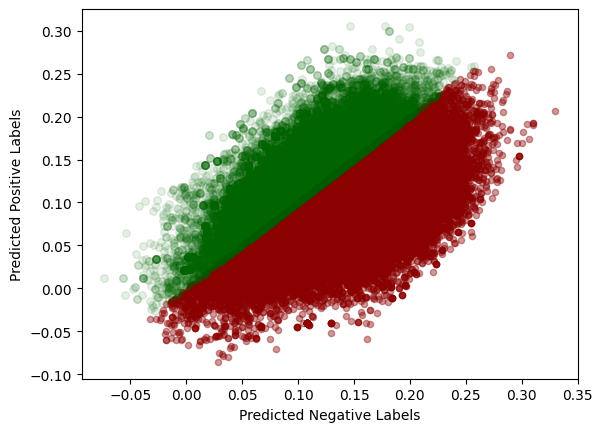

In [24]:
actual_pos_filt = df['topn_semantic_sentiment_polarity'] == 1
actual_neg_filt =  df['topn_semantic_sentiment_polarity'] == 0

# filter positive and negative review based on Most Probable predicted 'y' or 'topn_semantic_sentiment_score' column
predicted_pos_filt = df['topn_semantic_sentiment_polarity'] == 1
predicted_neg_filt = df['topn_semantic_sentiment_polarity'] == 0



# plotting Semantic Sentiment Score Position of Actual Negative Reviews 
plt.scatter(df['topn_NSS'][actual_neg_filt], 
         df['topn_PSS'][actual_neg_filt],  
         label='Actual Negetive Reviews',
           color='DarkRed',
            alpha=0.4 , # set transparency of color
            s=20 # set size of dots
           )

# plotting Semantic Sentiment Score Position of Actual Positive Reviews 
plt.scatter(df['topn_NSS'][actual_pos_filt], 
         df['topn_PSS'][actual_pos_filt],  
         label='Actual Positive Reviews',
       color='DarkGreen',
            alpha=0.1, # set transparency of color
            s=30 # set size of dots
           )
# naming the x & y axis
plt.xlabel('Predicted Negative Labels')
plt.ylabel('Predicted Positive Labels')

# Sentiment Analysis Using BERT

In [25]:
!pip install transformers

In [26]:

# importing the pipeline module
from transformers import pipeline
 
# Downloading the sentiment analysis model
SentimentClassifier = pipeline("sentiment-analysis")

# Downloading the sentiment analysis model
# SentimentClassifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [27]:
# Defining a function to call for the whole dataframe
def FunctionBERTSentiment(inpText):
  return(SentimentClassifier(inpText)[0]['label'])

In [28]:
df['BERT_Sentiment']=df['Text'].apply(FunctionBERTSentiment)
df.head(10)

,id_no,Main Topic,Subtopic,Content,Text,tokenized_text,tokenized_text_len,overall_PSS,overall_NSS,overall_semantic_sentiment_score,overall_semantic_sentiment_polarity,topn_PSS,topn_NSS,topn_semantic_sentiment_score,topn_semantic_sentiment_polarity,BERT_Sentiment
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,borderland positive coming border kill,"[borderland, positive, coming, border, kill]",5,0.358573,0.258817,0.099755,1,0.168040,0.140596,0.027444,1,POSITIVE
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,borderland positive im getting borderland kill,"[borderland, positive, im, getting, borderland...",6,0.218879,0.298876,-0.079996,0,0.093349,0.134112,-0.040763,0,POSITIVE
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,borderland positive im coming borderland murder,"[borderland, positive, im, coming, borderland,...",6,0.251232,0.219235,0.031997,1,0.110193,0.109128,0.001064,1,POSITIVE
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,borderland positive im getting borderland 2 mu...,"[borderland, positive, im, getting, borderland...",7,0.216471,0.289112,-0.072642,0,0.090914,0.124242,-0.033328,0,POSITIVE
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,borderland positive im getting borderland murder,"[borderland, positive, im, getting, borderland...",6,0.217454,0.278964,-0.061510,0,0.092808,0.128594,-0.035786,0,POSITIVE
5,2402,Borderlands,Positive,So I spent a few hours making something for fu...,borderland positive spent hour making somethin...,"[borderland, positive, spent, hour, making, so...",29,0.476575,0.539113,-0.062538,0,0.165047,0.161863,0.003184,1,POSITIVE
6,2402,Borderlands,Positive,So I spent a couple of hours doing something f...,borderland positive spent couple hour somethin...,"[borderland, positive, spent, couple, hour, so...",29,0.481999,0.538108,-0.056108,0,0.168236,0.161181,0.007055,1,POSITIVE
7,2402,Borderlands,Positive,So I spent a few hours doing something for fun...,borderland positive spent hour something fun k...,"[borderland, positive, spent, hour, something,...",14,0.460148,0.462581,-0.002433,0,0.169047,0.160958,0.008089,1,POSITIVE
8,2402,Borderlands,Positive,So I spent a few hours making something for fu...,borderland positive spent hour making somethin...,"[borderland, positive, spent, hour, making, so...",29,0.477177,0.533266,-0.056088,0,0.165764,0.161945,0.003818,1,POSITIVE
9,2402,Borderlands,Positive,2010 So I spent a few hours making something f...,borderland positive 2010 spent hour making som...,"[borderland, positive, 2010, spent, hour, maki...",30,0.471359,0.528984,-0.057625,0,0.155397,0.154174,0.001223,1,POSITIVE


In [29]:
# Defining a function to call for the whole dataframe
def FunctionBERTScore(inpText):
  return(SentimentClassifier(inpText)[0]['score'])

In [30]:
df['Score']=df['Text'].apply(FunctionBERTScore)
df.head(10)

,id_no,Main Topic,Subtopic,Content,Text,tokenized_text,tokenized_text_len,overall_PSS,overall_NSS,overall_semantic_sentiment_score,overall_semantic_sentiment_polarity,topn_PSS,topn_NSS,topn_semantic_sentiment_score,topn_semantic_sentiment_polarity,BERT_Sentiment,Score
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,borderland positive coming border kill,"[borderland, positive, coming, border, kill]",5,0.358573,0.258817,0.099755,1,0.168040,0.140596,0.027444,1,POSITIVE,0.992966
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,borderland positive im getting borderland kill,"[borderland, positive, im, getting, borderland...",6,0.218879,0.298876,-0.079996,0,0.093349,0.134112,-0.040763,0,POSITIVE,0.838804
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,borderland positive im coming borderland murder,"[borderland, positive, im, coming, borderland,...",6,0.251232,0.219235,0.031997,1,0.110193,0.109128,0.001064,1,POSITIVE,0.958094
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,borderland positive im getting borderland 2 mu...,"[borderland, positive, im, getting, borderland...",7,0.216471,0.289112,-0.072642,0,0.090914,0.124242,-0.033328,0,POSITIVE,0.988176
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,borderland positive im getting borderland murder,"[borderland, positive, im, getting, borderland...",6,0.217454,0.278964,-0.061510,0,0.092808,0.128594,-0.035786,0,POSITIVE,0.974468
5,2402,Borderlands,Positive,So I spent a few hours making something for fu...,borderland positive spent hour making somethin...,"[borderland, positive, spent, hour, making, so...",29,0.476575,0.539113,-0.062538,0,0.165047,0.161863,0.003184,1,POSITIVE,0.990503
6,2402,Borderlands,Positive,So I spent a couple of hours doing something f...,borderland positive spent couple hour somethin...,"[borderland, positive, spent, couple, hour, so...",29,0.481999,0.538108,-0.056108,0,0.168236,0.161181,0.007055,1,POSITIVE,0.993713
7,2402,Borderlands,Positive,So I spent a few hours doing something for fun...,borderland positive spent hour something fun k...,"[borderland, positive, spent, hour, something,...",14,0.460148,0.462581,-0.002433,0,0.169047,0.160958,0.008089,1,POSITIVE,0.998136
8,2402,Borderlands,Positive,So I spent a few hours making something for fu...,borderland positive spent hour making somethin...,"[borderland, positive, spent, hour, making, so...",29,0.477177,0.533266,-0.056088,0,0.165764,0.161945,0.003818,1,POSITIVE,0.989587
9,2402,Borderlands,Positive,2010 So I spent a few hours making something f...,borderland positive 2010 spent hour making som...,"[borderland, positive, 2010, spent, hour, maki...",30,0.471359,0.528984,-0.057625,0,0.155397,0.154174,0.001223,1,POSITIVE,0.992931


In [31]:
df['Content_BERT_Sentiment']=df['Content'].apply(FunctionBERTSentiment)
df.head(10)

,id_no,Main Topic,Subtopic,Content,Text,tokenized_text,tokenized_text_len,overall_PSS,overall_NSS,overall_semantic_sentiment_score,overall_semantic_sentiment_polarity,topn_PSS,topn_NSS,topn_semantic_sentiment_score,topn_semantic_sentiment_polarity,BERT_Sentiment,Score,Content_BERT_Sentiment
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,borderland positive coming border kill,"[borderland, positive, coming, border, kill]",5,0.358573,0.258817,0.099755,1,0.168040,0.140596,0.027444,1,POSITIVE,0.992966,POSITIVE
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,borderland positive im getting borderland kill,"[borderland, positive, im, getting, borderland...",6,0.218879,0.298876,-0.079996,0,0.093349,0.134112,-0.040763,0,POSITIVE,0.838804,POSITIVE
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,borderland positive im coming borderland murder,"[borderland, positive, im, coming, borderland,...",6,0.251232,0.219235,0.031997,1,0.110193,0.109128,0.001064,1,POSITIVE,0.958094,NEGATIVE
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,borderland positive im getting borderland 2 mu...,"[borderland, positive, im, getting, borderland...",7,0.216471,0.289112,-0.072642,0,0.090914,0.124242,-0.033328,0,POSITIVE,0.988176,POSITIVE
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,borderland positive im getting borderland murder,"[borderland, positive, im, getting, borderland...",6,0.217454,0.278964,-0.061510,0,0.092808,0.128594,-0.035786,0,POSITIVE,0.974468,NEGATIVE
5,2402,Borderlands,Positive,So I spent a few hours making something for fu...,borderland positive spent hour making somethin...,"[borderland, positive, spent, hour, making, so...",29,0.476575,0.539113,-0.062538,0,0.165047,0.161863,0.003184,1,POSITIVE,0.990503,NEGATIVE
6,2402,Borderlands,Positive,So I spent a couple of hours doing something f...,borderland positive spent couple hour somethin...,"[borderland, positive, spent, couple, hour, so...",29,0.481999,0.538108,-0.056108,0,0.168236,0.161181,0.007055,1,POSITIVE,0.993713,NEGATIVE
7,2402,Borderlands,Positive,So I spent a few hours doing something for fun...,borderland positive spent hour something fun k...,"[borderland, positive, spent, hour, something,...",14,0.460148,0.462581,-0.002433,0,0.169047,0.160958,0.008089,1,POSITIVE,0.998136,POSITIVE
8,2402,Borderlands,Positive,So I spent a few hours making something for fu...,borderland positive spent hour making somethin...,"[borderland, positive, spent, hour, making, so...",29,0.477177,0.533266,-0.056088,0,0.165764,0.161945,0.003818,1,POSITIVE,0.989587,NEGATIVE
9,2402,Borderlands,Positive,2010 So I spent a few hours making something f...,borderland positive 2010 spent hour making som...,"[borderland, positive, 2010, spent, hour, maki...",30,0.471359,0.528984,-0.057625,0,0.155397,0.154174,0.001223,1,POSITIVE,0.992931,NEGATIVE


In [32]:
# df.to_csv('bert_sentiment.csv', index=False)

<AxesSubplot: >

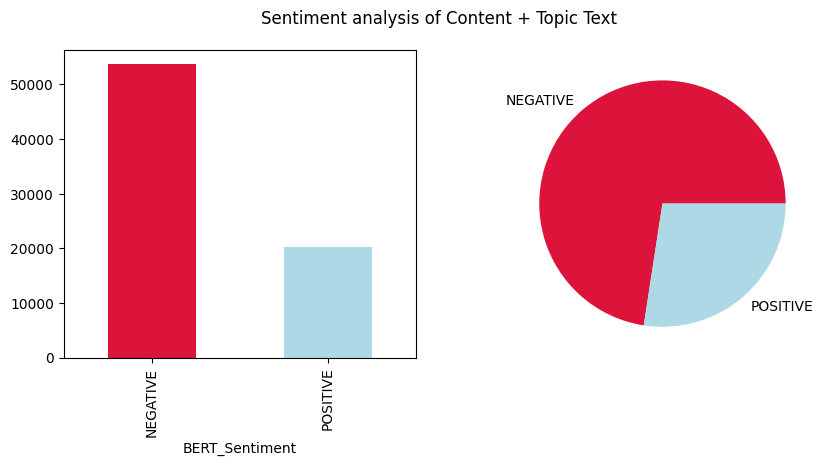

In [33]:
import matplotlib.pyplot as plt
fig, subPlot =plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.suptitle("Sentiment analysis of Content + Topic Text")
 
# Grouping the data
GroupedData=df.groupby('BERT_Sentiment').size()
 
# Creating the charts
GroupedData.plot(kind='bar', ax=subPlot[0], color=['crimson', 'lightblue'])
GroupedData.plot(kind='pie', ax=subPlot[1], colors=['crimson', 'lightblue'])

<AxesSubplot: >

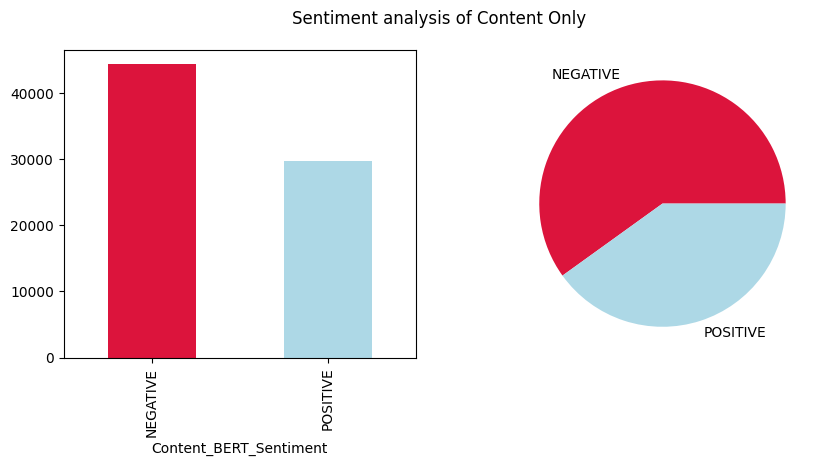

In [34]:
import matplotlib.pyplot as plt
fig, subPlot =plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.suptitle("Sentiment analysis of Content Only")
 
# Grouping the data
GroupedData=df.groupby('Content_BERT_Sentiment').size()
 
# Creating the charts
GroupedData.plot(kind='bar', ax=subPlot[0], color=['crimson', 'lightblue'])
GroupedData.plot(kind='pie', ax=subPlot[1], colors=['crimson', 'lightblue'])